Nama    : Rhafael Chandra \
NIM     : 22/498550/PA/21528

# Information Retrieval Assignment - Simple IR using Boolean Retrieval

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import re
import time

from collections import defaultdict

from numpy import random
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

sns.set_style("whitegrid")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data Exploration

In [2]:
df = pd.read_csv('./News.csv').set_index('id')
df.head()

,id_author,title,portal,time,author,editor,content,source
id,,,,,,,,
0,1,Infografis Pekerja Asing Dilarang Masuk Wilaya...,Liputan6.com,"24 Jul 2021, 09:02 WIB",Abdillah,Abdillah,Pemerintah melalui Menteri Hukum dan Hak Asasi...,https://www.liputan6.com/news/read/4614451/inf...
1,1,Infografis Jadwal Bulu Tangkis Indonesia di Ol...,Liputan6.com,"23 Jul 2021, 23:23 WIB",Abdillah,Abdillah,Bulu Tangkis menjadi andalan Indonesia berburu...,https://www.liputan6.com/bola/read/4614427/inf...
2,1,"Infografis Jangan Bebal, Kamu Tidak Kebal Covi...",Liputan6.com,"23 Jul 2021, 10:40 WIB",Abdillah,Abdillah,Covid-19 tidak mengenal usia dan status. Siapa...,https://www.liputan6.com/news/read/4613233/inf...
3,1,Infografis Awas Perokok Lebih Rentan Tertular ...,Liputan6.com,"22 Jul 2021, 10:35 WIB",Abdillah,Abdillah,Kebiasaan merokok berisiko menimbulkan sejumla...,https://www.liputan6.com/news/read/4612324/inf...
4,1,Infografis Perbedaan Aturan PPKM Level 3 dan 4,Liputan6.com,"22 Jul 2021, 09:01 WIB",Abdillah,Abdillah,Pemberlakuan Pembatasan Kegiatan Masyarakat at...,https://www.liputan6.com/news/read/4612511/inf...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14343 entries, 0 to 14343
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_author  14343 non-null  int64 
 1   title      14343 non-null  object
 2   portal     14343 non-null  object
 3   time       14343 non-null  object
 4   author     14343 non-null  object
 5   editor     14343 non-null  object
 6   content    14334 non-null  object
 7   source     14193 non-null  object
dtypes: int64(1), object(7)
memory usage: 1008.5+ KB


Dataset terdiri dari 8 kolom, yaitu:
- `id_author`   : id penulis berita
- `title`       : judul berita
- `portal`      : portal berita
- `time`        : waktu berita diposting
- `author`      : penulis berita
- `editor`      : editor berita
- `content`     : isi berita
- `source`      : sumber berita (url)

In [4]:
df.shape

(14343, 8)

Dataset terdiri dari 8 kolom dan 14343 baris.

In [5]:
df.isnull().sum()

,0
id_author,0
title,0
portal,0
time,0
author,0
editor,0
content,9
source,150


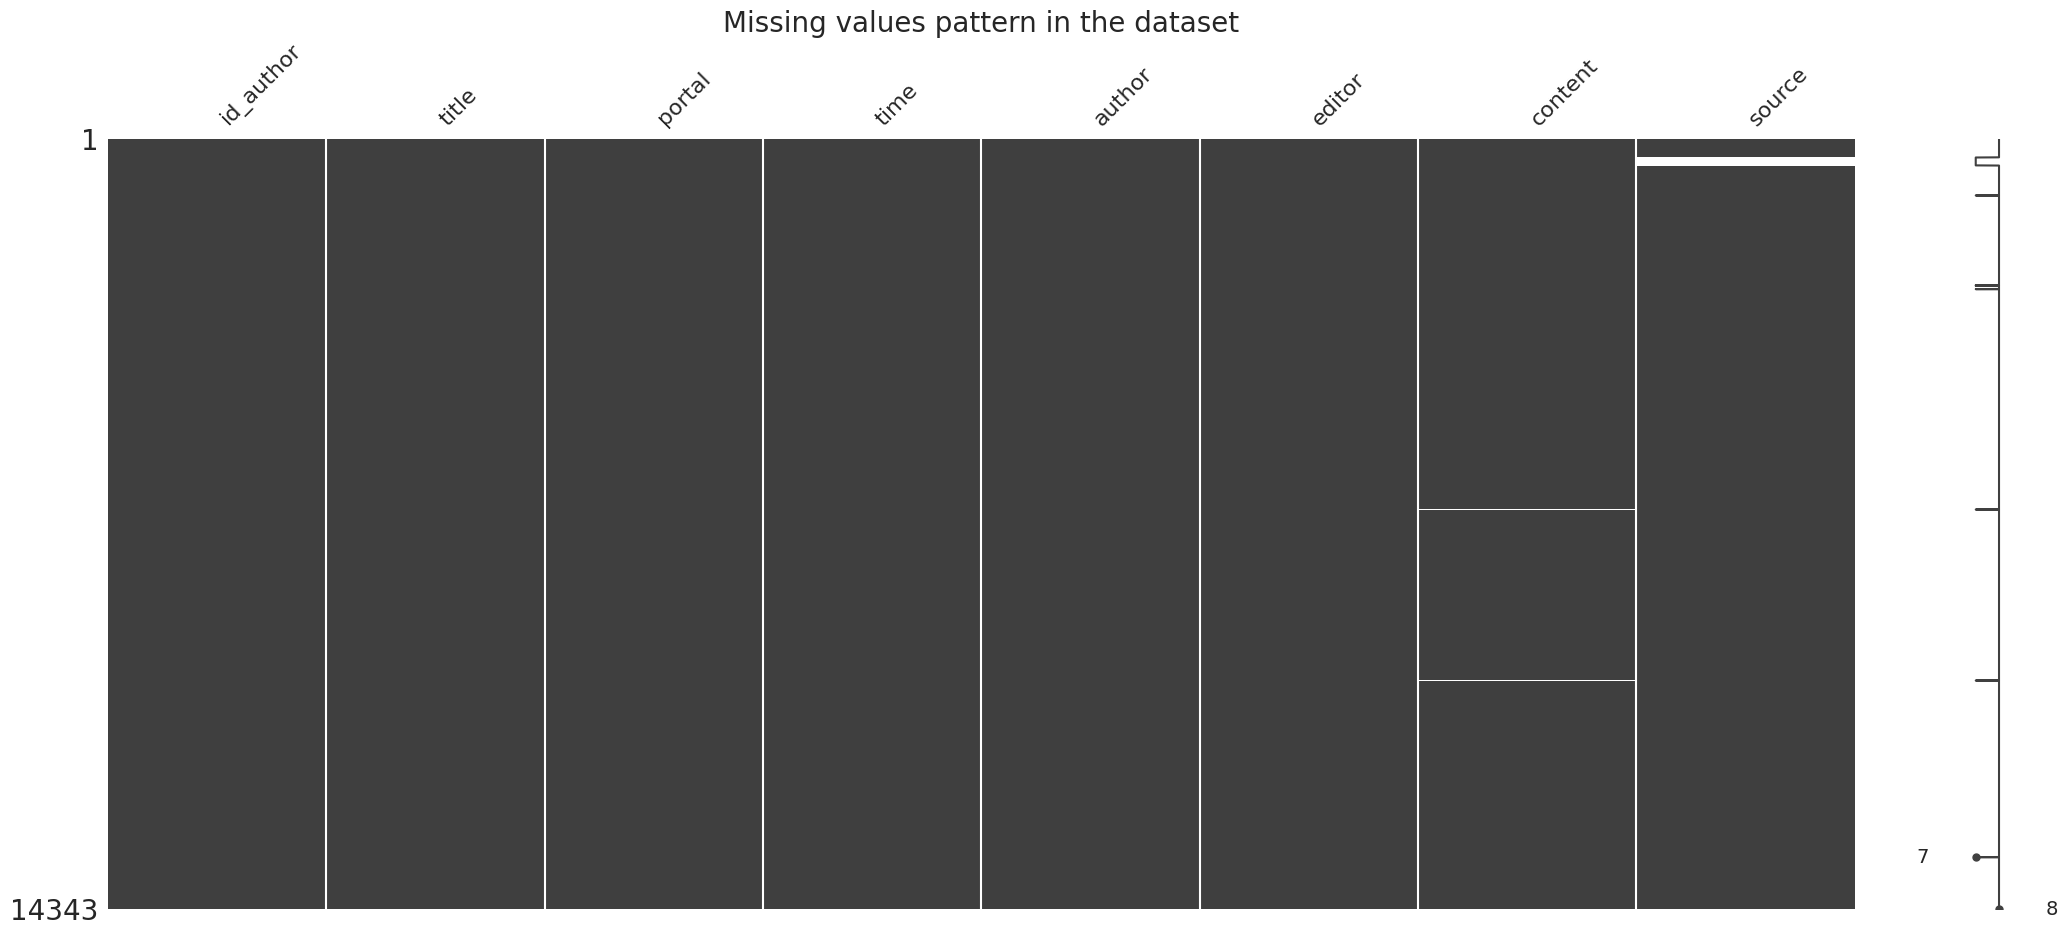

In [6]:
msno.matrix(df)
plt.title('Missing values pattern in the dataset', fontsize=20)
plt.show()

Terdapat sebanyak 9 missing values pada `content` dan 150 missing values pada `source`.

In [7]:
dup_len = df[df.duplicated()].shape[0]
dup_percentage = "{:.2%}".format(dup_len / df.shape[0])
print(f'Duplicated data: {dup_percentage} ({dup_len})')

Duplicated data: 0.85% (122)


Terdapat beberapa data yang terduplikat, sebanyak 122 baris (0.05%) dari keseluruhan data.

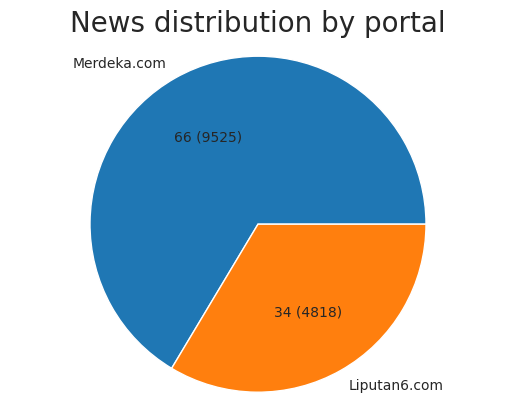

In [8]:
portal_counts = df['portal'].value_counts()
portal_counts.plot.pie(autopct=lambda x: f'{x:.0f} ({x * len(df) / 100:.0f})')
plt.title('News distribution by portal', fontsize=20)
plt.ylabel('')
plt.axis('equal')
plt.show()

Terdapat 2 portal yang ada di dataset dengan persebarannya adalah:
- `Merdeka.com` (66.4%)
- `Liputan6.com` (33.6%)

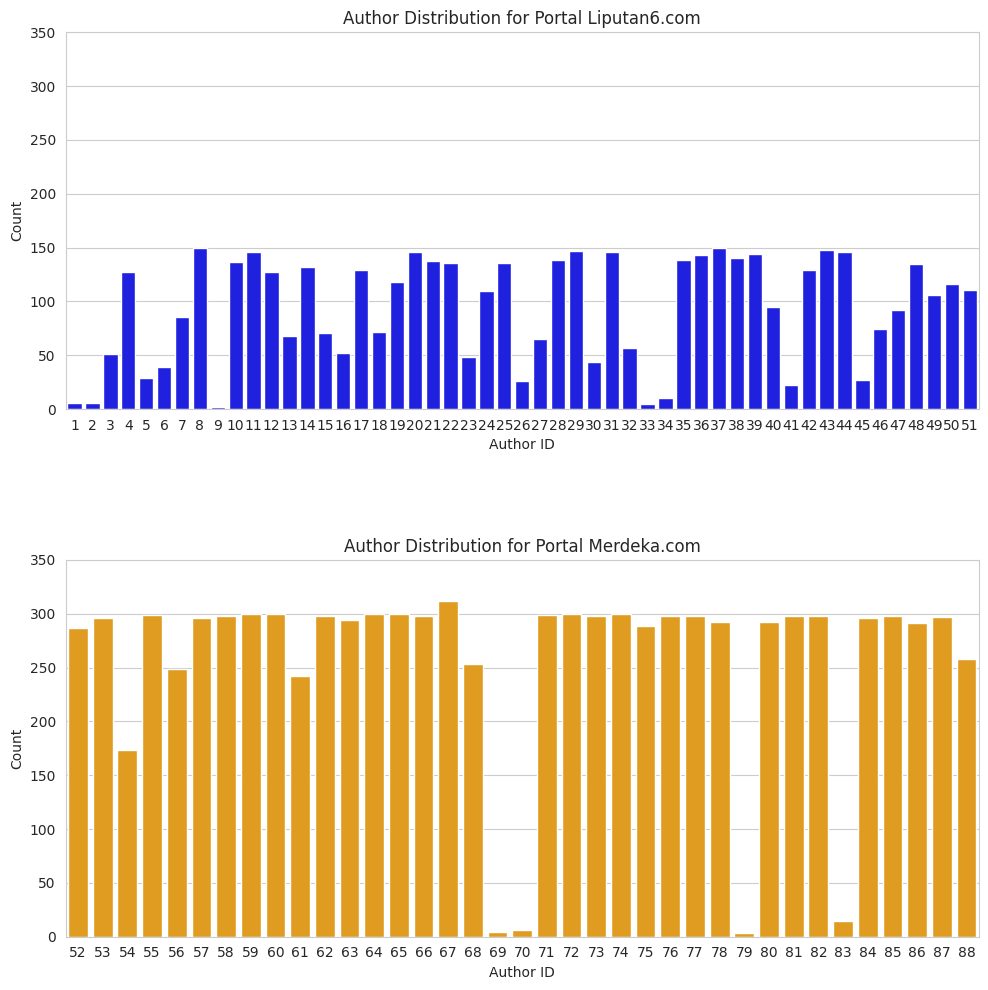

In [9]:

grouped_df = df.groupby(['portal', 'id_author']).agg({'author': 'count'}).reset_index()
grouped_df.rename(columns={'author': 'count'}, inplace=True)

portals = grouped_df['portal'].unique()

colors = ['blue', 'orange']

fig, axes = plt.subplots(nrows=len(portals), ncols=1, figsize=(10, 5 * len(portals)))
if len(portals) == 1:
    axes = [axes]

for ax, (portal, color) in zip(axes, zip(portals, colors)):
    portal_data = grouped_df[grouped_df['portal'] == portal]

    sns.barplot(
        data=portal_data,
        x='id_author',
        y='count',
        ax=ax,
        color=color,
        errorbar=None,
        legend=False
    )

    ax.set_title(f'Author Distribution for Portal {portal}')
    ax.set_xlabel('Author ID')
    ax.set_ylabel('Count')
    # set ylim
    ax.set_ylim(0, 350)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

plt.show()

- Penulis berita dari portal `merdeka.com` cenderung memiliki jumlah berita yang sama dan lebih banyak dibandingkan dengan penulis berita dari portal `liputan6.com`.
- Penulis berita dari portal `liputan6.com` cenderung memiliki jumlah berita yang fluktuatif.

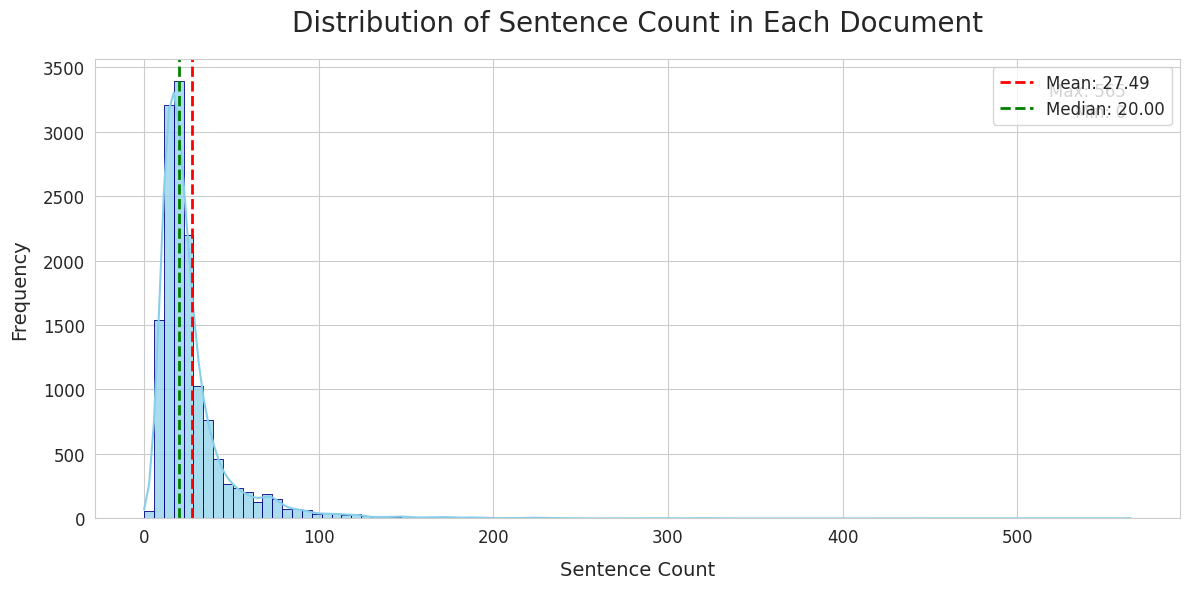

In [10]:
count_sentence = df['content'].apply(lambda x: len(re.findall(r'\.', x)) if type(x) == str else 0)
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(data=count_sentence, bins=100, kde=True, color='skyblue', edgecolor='navy', alpha=0.7, ax=ax)

plt.title('Distribution of Sentence Count in Each Document', fontsize=20, pad=20)
plt.xlabel('Sentence Count', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

mean_count = np.mean(count_sentence)
plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_count:.2f}')

median_count = np.median(count_sentence)
plt.axvline(median_count, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_count:.2f}')

plt.legend(fontsize=12, loc='upper right')

max_count = np.max(count_sentence)
min_count = np.min(count_sentence)
plt.text(0.95, 0.95, f'Max: {max_count}\nMin: {min_count}',
         transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12)

plt.tight_layout()
plt.show()

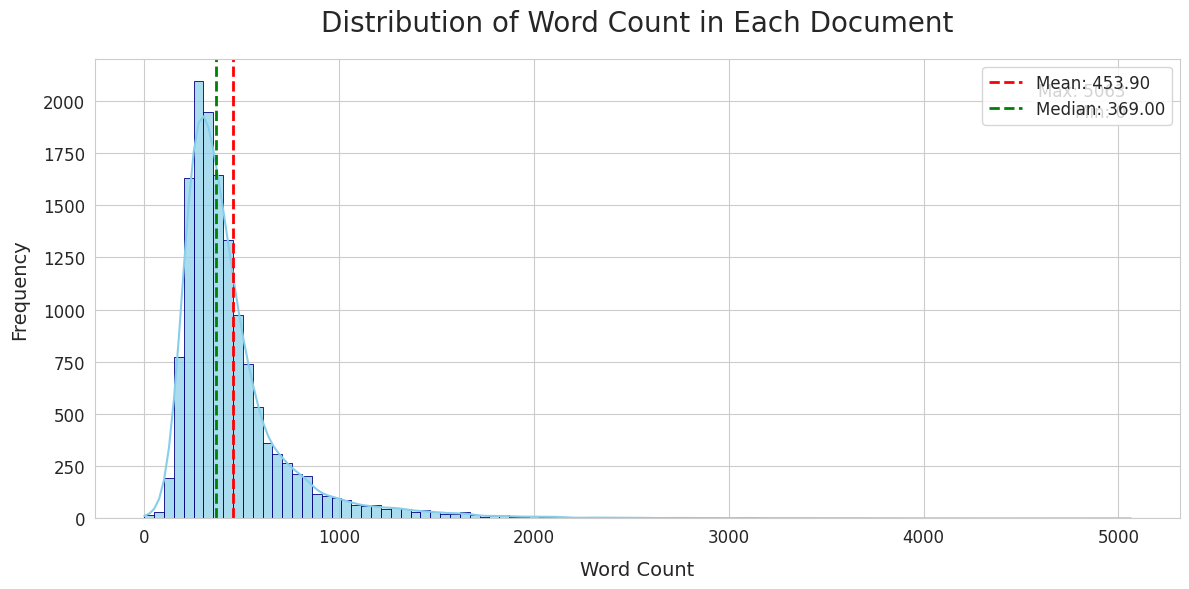

In [11]:
tmp = df['content'].apply(lambda x: word_tokenize(x) if type(x) == str else [])

# count word in docs
tmp = tmp.apply(lambda x: len(x))
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(data=tmp, bins=100, kde=True, color='skyblue', edgecolor='navy', alpha=0.7, ax=ax)

plt.title('Distribution of Word Count in Each Document', fontsize=20, pad=20)
plt.xlabel('Word Count', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

mean_count = np.mean(tmp)
plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_count:.2f}')

median_count = np.median(tmp)
plt.axvline(median_count, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_count:.2f}')

plt.legend(fontsize=12, loc='upper right')

max_count = np.max(tmp)
min_count = np.min(tmp)
plt.text(0.95, 0.95, f'Max: {max_count}\nMin: {min_count}',
         transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12)

plt.tight_layout()
plt.show()

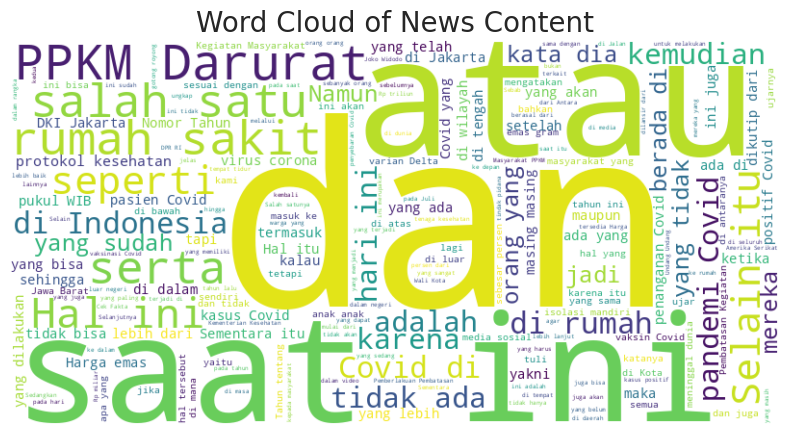

In [12]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['content'].dropna().values))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Content', fontsize=20)
plt.show()

# Inverted Index

Inverted index akan dibuat pada kolom `content`. Dari data exploration, ditemukan bahwa kolom tersebut memiliki 9 missing values sehingga perlu ditangani terlebih dahulu dengan dihapus.

## Handle missing values

In [13]:
df_content = df['content'].copy()
df_content.index = df.index
df_content.dropna(inplace=True)
print(f"Before: {len(df['content'])}")
print(f'After: {len(df_content)}')
print(f'Difference: {len(df["content"]) - len(df_content)}')

Before: 14343
After: 14334
Difference: 9


## Handle duplicated data

In [14]:
tmp = df_content.drop_duplicates()
print(f"Before: {len(df['content'])}")
print(f'After: {len(tmp)}')
print(f'Difference: {len(df_content) - len(tmp)}')
df_content = tmp

Before: 14343
After: 14211
Difference: 123


In [15]:
df_content = pd.DataFrame(df_content, columns=['content'])
df_content.head()

,content
id,
0,Pemerintah melalui Menteri Hukum dan Hak Asasi...
1,Bulu Tangkis menjadi andalan Indonesia berburu...
2,Covid-19 tidak mengenal usia dan status. Siapa...
3,Kebiasaan merokok berisiko menimbulkan sejumla...
4,Pemberlakuan Pembatasan Kegiatan Masyarakat at...


## Tokenization

Inverted Index

1. Explore the dataset that contains news from several authors, provide the statistical details of this document collections (how many docs, words/terms, sentences). Download the dataset from this link https://drive.google.com/file/d/13UUj240WKjosQnLfnveMcOutd0OYxBDF/view?usp=sharing  and use text under the "content" column.

2. Create inverted index based on the document collections (term based)

3. Create simple Boolean Retrieval, for merging (AND), union (OR) and negation (NOT). Check the performance of your Boolean Retrieval, by trying at least 5 queries for each of the logical operator.

4. Record the time needed for creating inverted index and for retrieving queries.

5. Apply query optimization (if necessary) and then compare the again the time needed for retrieving queries.

In [16]:
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter_ns()
        result = func(*args, **kwargs)
        duration = time.perf_counter_ns() - start
        wrapper.total_time += duration
        if duration > 1e9:
            print(f"Execution time: {duration / 1e9} s")
        else:
            print(f"Execution time: {duration} ns")
        return result

    wrapper.total_time = 0
    return wrapper

## Inverted Index

In [17]:
word_tokenize

<function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>

In [18]:
def tokenize_word(df=df_content['content']):
    return df.apply(word_tokenize)

def create_inverted_index(df):
    def def_value():
        return [0, []]
    inv_idx = defaultdict(def_value)

    for i in range(len(df)):
        id = df.index[i]
        doc = df[id]
        s = set()
        for term in doc:
            if term not in s:
                inv_idx[term][0] += 1
                inv_idx[term][1].append(id)
                s.add(term)
    return inv_idx

@timer
def get_universe_and_inverted_index(df, df_raw, col):
    df_tokenized = tokenize_word(df[col])
    inv_idx = create_inverted_index(df_tokenized)

    universe = [len(df_raw), [i for i in range(len(df_raw))]]
    return universe, inv_idx

In [19]:
universe, inverted_index = get_universe_and_inverted_index(df_content, df, 'content')

Execution time: 52.864378994 s


In [20]:
print(f"Universe Length: {universe[0]}")
print(f"Terms Length: {len(inverted_index)}")

Universe Length: 14343
Terms Length: 136705


Terdapat 136705 terms pada dataset setelah ditokenisasi.

## Query Handling

### NOT

In [21]:
def NOT(query, universe=universe):
    i = 0 # universe
    j = 0 # inverted
    ans = [0, []]
    if query[0] == 0:
        return universe

    while i < universe[0] and j < query[0]:
        if universe[1][i] < query[1][j]:
            ans[0] += 1
            ans[1].append(universe[1][i])
            i += 1
        else:
            i += 1
            j += 1

    while i < universe[0]:
        ans[0] += 1
        ans[1].append(universe[1][i])
        i += 1

    return ans

### OR

In [22]:
def OR(query1, query2):
    ans = [0, []]
    p1 = 0 # pointer query1
    p2 = 0 # pointer query2

    while p1 < len(query1[1]) and p2 < len(query2[1]):
        if query1[1][p1] < query2[1][p2]:
            ans[0] += 1
            ans[1].append(query1[1][p1])
            p1 += 1
        elif query2[1][p2] < query1[1][p1]:
            ans[0] += 1
            ans[1].append(query2[1][p2])
            p2 += 1
        else:
            ans[0] += 1
            ans[1].append(query1[1][p1])
            p1 += 1
            p2 += 1

    while p1 < len(query1[1]):
        ans[0] += 1
        ans[1].append(query1[1][p1])
        p1 += 1

    while p2 < len(query2[1]):
        ans[0] += 1
        ans[1].append(query2[1][p2])
        p2 += 1

    return ans

### AND

In [23]:
def AND(query1, query2):
    ans = [0, []]
    p1 = 0 # pointer query1
    p2 = 0 # pointer query2

    while p1 < len(query1[1]) and p2 < len(query2[1]):
        if query1[1][p1] < query2[1][p2]:
            p1 += 1
        elif query2[1][p2] < query1[1][p1]:
            p2 += 1
        else:
            ans[0] += 1
            ans[1].append(query1[1][p1])
            p1 += 1
            p2 += 1
    return ans

### Boolean Retrieval (Expression Tree)

In [33]:
class Node:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None

class ExpressionTree:
    def __init__(self):
        self.root = None
        self.prio = {
            '(': 1,
            'OR': 2,
            'AND': 3,
            'NOT': 4
        }

    def __get_token(self, s, inv_idx):
        arr = s.split()
        ans = []

        tmp = {'AND', 'OR', 'NOT', '(', ')'}

        for token in arr:
            if token not in tmp:
                ans.append(inv_idx.get(token, [0, []]))
                continue
            ans.append(token)
        return ans

    def build(self, s, inv_idx):
        tokens = self.__get_token(s, inv_idx)
        i = 0
        while i < len(tokens) - 1:
            if tokens[i] == 'NOT' and tokens[i + 1] == 'NOT':
                del tokens[i]
                del tokens[i]
            else:
                i += 1

        ops = []
        stack = []

        for token in tokens:
            if token == '(':
                ops.append(token)
            elif token == ')':
                while ops[-1] != '(':
                    self.combine(ops, stack)
                ops.pop()
            elif not isinstance(token, str):
                stack.append(Node(token))
            else:
                while ops and self.prio.get(ops[-1], 0) >= self.prio[token]:
                    self.combine(ops, stack)
                ops.append(token)

        while ops:
            self.combine(ops, stack)

        self.root = stack[0] if stack else None

    def combine(self, ops, stack):
        root = Node(ops.pop())

        if root.data == 'NOT':
            if stack:
                root.right = stack.pop()
            else:
                root.right = None
            root.left = Node(-1)
        else:
            root.right = stack.pop()
            root.left = stack.pop()

        stack.append(root)

    def evaluate(self, root):
        if root is None:
            return [0, []]

        if root.left is None and root.right is None:
            return root.data

        L = self.evaluate(root.left)
        R = self.evaluate(root.right)
        if root.data == 'AND':
            return AND(L, R)
        elif root.data == 'OR':
            return OR(L, R)
        elif root.data == 'NOT':
            return NOT(R)

    def post_print(self, root):
        if not root:
            return

        self.post_print(root.left)
        self.post_print(root.right)
        print(root.data, end=' ')

class BooleanRetrieval:
    def __init__(self, inv_idx):
        self.inv_idx = inv_idx

    def evaluate(self, s):
        ext = ExpressionTree()
        ext.build(s, self.inv_idx)
        return ext.evaluate(ext.root)


### Boolean Retrieval (Optimized)

In [34]:
class BooleanRetrievalOpt:
    def __init__(self, inv_idx):
        self.inv_idx = inv_idx

    def __get_token(self, s):
        arr = s.split()
        ans = []

        tmp = {'AND', 'OR', 'NOT', '(', ')'}

        for token in arr:
            if token not in tmp:
                ans.append(self.inv_idx.get(token, [0, []]))
                continue
            ans.append(token)
        return ans


    def __eval_same_ops(self, tokens, ops):
        if len(tokens) == 1:
            return tokens

        if len(tokens) == 2:
            if ops == 'AND':
                return AND(tokens[0], tokens[1])
            elif ops == 'OR':
                return OR(tokens[0], tokens[1])

        sorted_tokens = sorted(tokens, key=lambda item: item[0], reverse=True)
        token1 = sorted_tokens.pop()
        token2 = sorted_tokens.pop()
        if ops == 'AND':
            res = AND(token1, token2)
        elif ops == 'OR':
            res = OR(token1, token2)
        sorted_tokens.append(res)
        return self.__eval_same_ops(sorted_tokens, ops)


    def __eval_no_bracket(self, tokens):
        # [[s,[]], 'AND', [s,[]]]

        # delete consecutive NOT
        i = 0
        while i < len(tokens) - 1:
            if tokens[i] == 'NOT' and tokens[i + 1] == 'NOT':
                del tokens[i]
                del tokens[i]
            else:
                i += 1


        while True:
            pos = -1
            for i in range(len(tokens) - 1, -1, -1):
                if tokens[i] == 'NOT':
                    pos = i
                    res = NOT(tokens[pos + 1])
                    tmp = tokens[:pos]
                    tmp.append(res)
                    for token in tokens[pos + 2:]:
                        tmp.append(token)
                    tokens = tmp
                    break

            if pos == -1:
                break

        while True:
            pos = -1
            for i in range(len(tokens)):
                if tokens[i] == 'AND':
                    pos = i
                    pos2 = i
                    for j in range(i + 2, len(tokens), 2):
                        if j >= len(tokens) - 1:
                            break
                        if tokens[j] != 'AND':
                            break
                        pos2 = j

                    tmp = []
                    for k in range(pos - 1, pos2 + 2, 2):
                        tmp.append(tokens[k])
                    res = self.__eval_same_ops(tmp, 'AND')
                    tmp = tokens[:pos - 1]
                    tmp.append(res)
                    for token in tokens[pos2 + 2:]:
                        tmp.append(token)
                    tokens = tmp
                    break
            if pos == -1:
                break


        while True:
            pos = -1
            for i in range(len(tokens)):
                if tokens[i] == 'OR':
                    pos = i
                    pos2 = i
                    for j in range(i + 2, len(tokens), 2):
                        if j >= len(tokens) - 1:
                            break
                        if tokens[j] != 'OR':
                            break
                        pos2 = j

                    tmp = []
                    for k in range(pos - 1, pos2 + 2, 2):
                        tmp.append(tokens[k])
                    res = self.__eval_same_ops(tmp, 'OR')
                    tmp = tokens[:pos - 1]
                    tmp.append(res)
                    for token in tokens[pos2 + 2:]:
                        tmp.append(token)
                    tokens = tmp
                    break
            if pos == -1:
                break

        if len(tokens) > 1:
            tokens = self.__eval_same_ops(tokens, 'OR')

        ans = tokens
        while not isinstance(ans[0], int):
            ans = ans[0]
        return ans

    def evaluate(self, s):
        tokens = self.__get_token(s)
        pos1 = -1 # (
        pos2 = -1 # )
        while True:
            pos2 = -1
            if len(tokens) == 1:
                break

            for i in range(len(tokens)):
                if tokens[i] == ')':
                    pos2 = i
                    break

            if pos2 != -1:
                pos1 = -1
                for j in range(pos2, -1, -1):
                    if tokens[j] == '(':
                        pos1 = j
                        break
                if pos2 == pos1 + 2:
                    res = tokens[pos1 + 1]
                else:
                    res = self.__eval_no_bracket(tokens[pos1 + 1:pos2])
                tmp = tokens[:pos1]
                tmp.append(res)
                for token in tokens[pos2 + 1:]:
                    tmp.append(token)
                tokens = tmp
            else:
                break
        if len(tokens) > 1:
            tokens = self.__eval_no_bracket(tokens)
        ans = tokens
        while not isinstance(ans[0], int):
            ans = ans[0]
        return ans

# Queries

## Query Generator

In [26]:

def get_term(inv_idx):
    keys = list(inv_idx.keys())
    res = random.choice(keys)
    while res in {'AND', 'NOT', '(', ')', 'OR'}:
        res = random.choice(keys)
    return res

def generate_query(inv_idx, approximate_length):
    depth = 0  # Track the number of open parentheses
    nterm = 0  # Track the number of terms added
    query = []

    # Start with either a term or a NOT operator
    choice = random.choice(['NOT', 'TERM'])

    while len(query) < approximate_length + 5:
        if choice == 'TERM':
            query.append(get_term(inv_idx))
            nterm += 1
            choice = random.choice(['AND', 'OR', ')'])
            if choice == ')' and depth == 0:  # If no open parentheses, prevent ')'
                choice = random.choice(['AND', 'OR'])

        elif choice == 'NOT':
            query.append('NOT')
            choice = random.choice(['(', 'TERM'])

        elif choice == '(':
            query.append('(')
            depth += 1
            choice = random.choice(['(', 'NOT', 'TERM'])

        elif choice == 'AND':
            if nterm > 0:  # term before and
                query.append('AND')
                choice = random.choice(['(', 'TERM'])

        elif choice == 'OR':
            if nterm > 0:  # term before or
                query.append('OR')
                choice = random.choice(['(', 'TERM'])

        elif choice == ')':
            if depth > 0:  # Only add ) if there are any (
                query.append(')')
                depth -= 1
                if depth == 0:  # dont and ) if no (
                    choice = random.choice(['AND', 'OR'])
                else:
                    choice = random.choice(['AND', 'OR', ')'])

        # check
        if len(query) >= approximate_length and query[-1] not in {'AND', 'OR', 'NOT', '('}:
            break

    # clean trailing ops
    while query and query[-1] in {'AND', 'OR', 'NOT', '('}:
        query.pop()

    # last check
    if nterm < 1 or len(query) < approximate_length or depth > 0:
        return generate_query(inv_idx, approximate_length)  # try again

    return ' '.join(query)

In [27]:
queries = {}
lengths = [5, 10, 15, 20, 25, 30]

for length in lengths:
    queries[length] = [generate_query(inverted_index, length) for _ in range(10)]

In [28]:
for length, queries_arr in queries.items():
    print(length)
    for query in queries_arr:
        print(query)
    print()

5
Margie AND dlu AND Reifansyah
946.20 OR Melong AND Retno
Dwi AND Astro AND Maryana
Covid-yang AND Kemenhub AND kalian
terpapar AND mun OR Cayetano
NOT ( NOT Latvia )
multidimensional OR ( 65.923 )
NOT bertumbangan OR FWA OR Manao
reaksinya OR Supri OR 82.687
NOT Pengajian AND Internalisasi OR 3.140

10
921 OR ( NOT masy ) OR Wave OR datum
NOT perketat AND Another OR Quebec OR Interactive AND pic.twitter.com/XzvNRT2Ifa—
NOT ( NOT bersabar ) AND an'amta OR Use/FoLU OR kemiriCara
luhut.pandjaitan AND menmbah AND ( NOT Gonzalez ) AND Colombia
motif-motif OR ( NOT HUSNUL OR Susandy OR pluralisme )
NOT Karyoto OR Fed AND momok AND Kitta OR berinvestasi
NOT ( NOT 08.57.46 AND Glucksman ) AND 1.832 AND bobber
NOT pulan AND Bong-soon AND Binjai AND Kepahiang/Polda OR Antopolog
Elektronika OR Salama OR ( displin ) AND 24.575.000 AND 5.855
mengirimimu AND masiv OR 11.985 AND KemenkopUKM AND densus OR Kuo

15
NOT Lapang AND ( Yonmek AND On OR ( NOT 193 ) ) AND Sikado
zone AND ( Infonya OR draina

In [35]:
def compare_query(query, inv_idx):
    start_br = time.perf_counter_ns()
    br = BooleanRetrieval(inv_idx)
    res_br = br.evaluate(query)
    count_br = time.perf_counter_ns() - start_br
    count_br = count_br / 1e6

    start_br_o = time.perf_counter_ns()
    br_o = BooleanRetrievalOpt(inv_idx)
    res_br_o = br_o.evaluate(query)
    count_br_o = time.perf_counter_ns() - start_br_o
    count_br_o = count_br_o / 1e6

    return count_br, count_br_o, (res_br == res_br_o)

In [36]:
res = []
for length, queries_arr in queries.items():
    for query in queries_arr:
        print(query)
        ans = compare_query(query, inverted_index)
        res.append([length, *ans])

Margie AND dlu AND Reifansyah
946.20 OR Melong AND Retno
Dwi AND Astro AND Maryana
Covid-yang AND Kemenhub AND kalian
terpapar AND mun OR Cayetano
NOT ( NOT Latvia )
multidimensional OR ( 65.923 )
NOT bertumbangan OR FWA OR Manao
reaksinya OR Supri OR 82.687
NOT Pengajian AND Internalisasi OR 3.140
921 OR ( NOT masy ) OR Wave OR datum
NOT perketat AND Another OR Quebec OR Interactive AND pic.twitter.com/XzvNRT2Ifa—
NOT ( NOT bersabar ) AND an'amta OR Use/FoLU OR kemiriCara
luhut.pandjaitan AND menmbah AND ( NOT Gonzalez ) AND Colombia
motif-motif OR ( NOT HUSNUL OR Susandy OR pluralisme )
NOT Karyoto OR Fed AND momok AND Kitta OR berinvestasi
NOT ( NOT 08.57.46 AND Glucksman ) AND 1.832 AND bobber
NOT pulan AND Bong-soon AND Binjai AND Kepahiang/Polda OR Antopolog
Elektronika OR Salama OR ( displin ) AND 24.575.000 AND 5.855
mengirimimu AND masiv OR 11.985 AND KemenkopUKM AND densus OR Kuo
NOT Lapang AND ( Yonmek AND On OR ( NOT 193 ) ) AND Sikado
zone AND ( Infonya OR drainase OR ( sf

In [37]:
df_res = pd.DataFrame(res, columns=['Query Items (approx)', 'Time (ms)', 'Time Opt (ms)', 'Result'])
df_res['Improve (float)'] = (df_res['Time (ms)'] - df_res['Time Opt (ms)']) / df_res['Time (ms)']  * 100
df_res['Improve (%)'] = df_res['Improve (float)'].apply(lambda x: f'{x:.2f}%')
df_res = df_res[['Query Items (approx)', 'Time (ms)', 'Time Opt (ms)', 'Improve (%)', 'Result', 'Improve (float)']]

display(df_res[[col for col in df_res.columns if col != 'Improve (float)']])

,Query Items (approx),Time (ms),Time Opt (ms),Improve (%),Result
0,5,0.066703,0.036658,45.04%,True
1,5,0.051212,0.029434,42.53%,True
2,5,0.075922,0.030430,59.92%,True
3,5,0.094188,0.063625,32.45%,True
4,5,0.201221,0.128877,35.95%,True
5,5,7.852866,6.948056,11.52%,True
6,5,0.041089,0.017238,58.05%,True
7,5,17.506995,11.546049,34.05%,True
8,5,0.055357,0.027890,49.62%,True
9,5,8.375594,7.255450,13.37%,True


In [38]:
df_res_grouped = df_res.groupby('Query Items (approx)').agg({
    'Time (ms)': 'mean',
    'Time Opt (ms)': 'mean',
}).reset_index()
df_res_grouped.columns = ['Query Items (approx)', 'Time (ms) (avg)', 'Time Opt (ms) (avg)']
df_res_grouped['Improve (float) (avg)'] = (df_res_grouped['Time (ms) (avg)'] - df_res_grouped['Time Opt (ms) (avg)']) / df_res_grouped['Time (ms) (avg)']  * 100

display(df_res_grouped)

,Query Items (approx),Time (ms) (avg),Time Opt (ms) (avg),Improve (float) (avg)
0,5,3.432115,2.608371,24.001063
1,10,10.226173,7.036737,31.188954
2,15,9.705648,8.350556,13.961897
3,20,24.112310,20.853683,13.514372
4,25,14.162325,9.971587,29.590749
5,30,43.103553,31.323429,27.329820


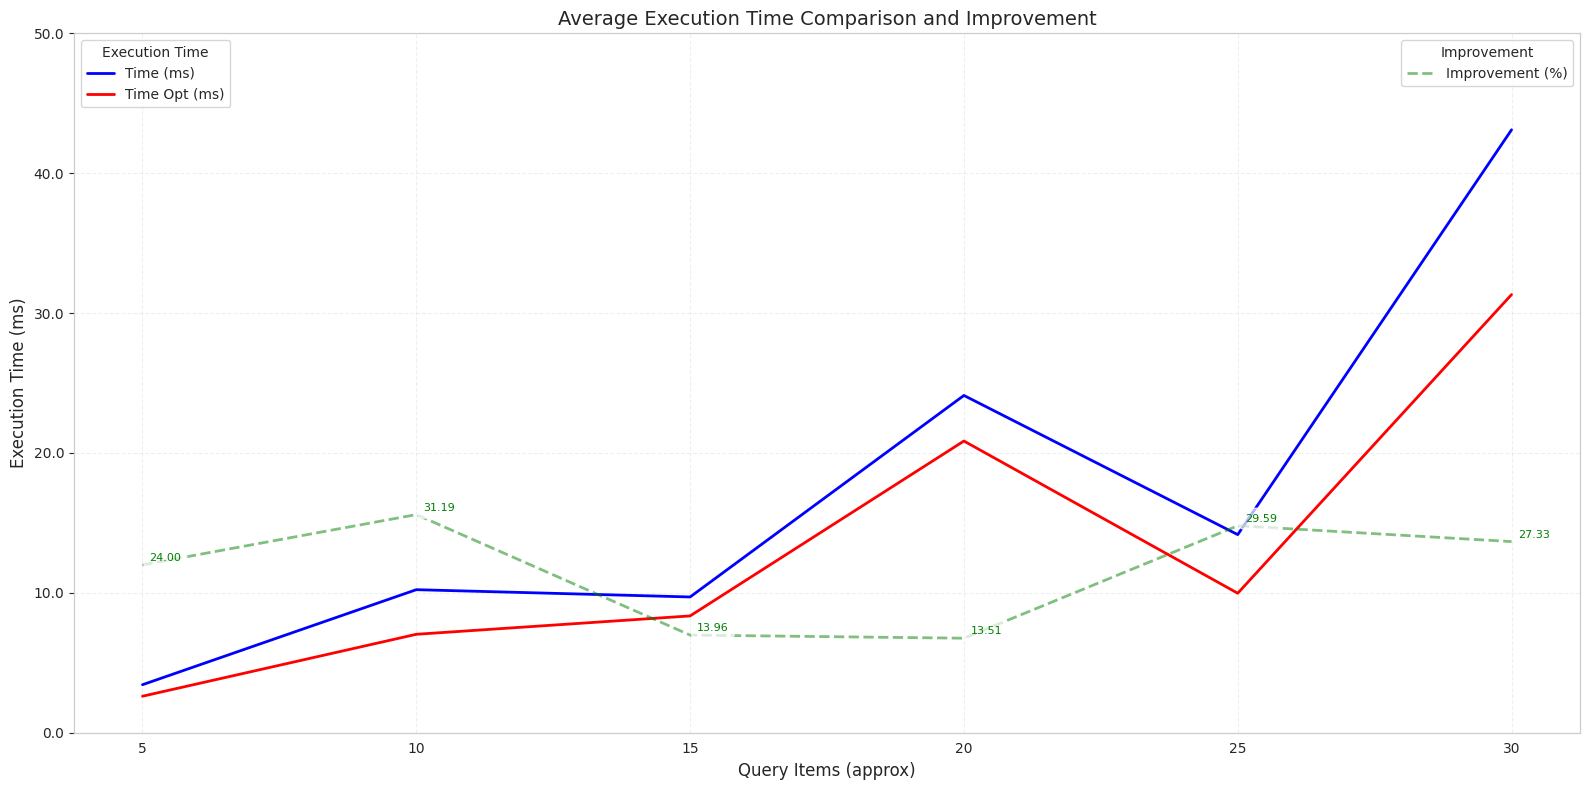

In [40]:
fig, ax1 = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_res_grouped, x='Query Items (approx)', y='Time (ms) (avg)', label='Time (ms)', ax=ax1, color='blue', linewidth=2)
sns.lineplot(data=df_res_grouped, x='Query Items (approx)', y='Time Opt (ms) (avg)', label='Time Opt (ms)', ax=ax1, color='red', linewidth=2)

ax1.set_xlabel('Query Items (approx)', fontsize=12)
ax1.set_ylabel('Execution Time (ms)', fontsize=12)
ax1.set_ylim(0, 50)

ax2 = ax1.twinx()

sns.lineplot(data=df_res_grouped, x='Query Items (approx)', y='Improve (float) (avg)', label='Improvement (%)', ax=ax2, color='green', alpha=0.5, linestyle='--', linewidth=2)

ax2.set_ylim(0, 100)
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_ylabel('')

plt.title('Average Execution Time Comparison and Improvement', fontsize=14)

ax1.legend(loc='upper left', fontsize=10, title='Execution Time')
ax2.legend(loc='upper right', fontsize=10, title='Improvement')

ax1.grid(True, linestyle='--', alpha=0.3)

ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

def add_labels(ax, x, y, labels, color, offset):
    for i, label in enumerate(labels):
        ax.annotate(f'{label:.2f}', (x[i], y[i]), xytext=(5, offset),
                    textcoords='offset points', ha='left', va='center',
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                    fontsize=8, color=color)

step = len(df_res_grouped) // 5  # Show 5 labels along each line
add_labels(ax2, df_res_grouped['Query Items (approx)'][::step], df_res_grouped['Improve (float) (avg)'][::step],
            df_res_grouped['Improve (float) (avg)'][::step], 'green', 5)

plt.tight_layout()

plt.show()